# Training with CDFG representation

In [1]:
!python -m pip list

Package                Version  
---------------------- ---------
absl-py                0.12.0   
anyio                  2.2.0    
argon2-cffi            20.1.0   
astunparse             1.6.3    
async-generator        1.10     
attrs                  20.3.0   
Babel                  2.9.0    
backcall               0.2.0    
bleach                 3.3.0    
cachetools             4.2.1    
certifi                2020.12.5
cffi                   1.14.5   
chardet                4.0.0    
cycler                 0.10.0   
dask                   2021.3.0 
decorator              4.4.2    
defusedxml             0.7.1    
entrypoints            0.3      
flatbuffers            1.12     
gast                   0.3.3    
google-auth            1.27.1   
google-auth-oauthlib   0.4.3    
google-pasta           0.2.0    
grpcio                 1.32.0   
h5py                   2.10.0   
idna                   2.10     
ipykernel              5.5.0    
ipython                7.21.0   
ipython-ge

In [2]:
!nvidia-smi

Fri Mar 19 23:21:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8     7W / 151W |     82MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm
import seaborn as sn
import numpy as np
import time

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, get_section

%matplotlib inline

In [4]:
def create_model(n_nodes, n_features, n_classes, learning_rate):
    N = n_nodes
    F = n_features
    # Model definition    
    conv   = GraphConv(45,activation='relu',use_bias=False)
    mincut = MinCutPool(N // 2)
    conv2  = GraphConv(55,activation='relu',use_bias=False)
    pool   = GlobalAttnSumPool()

    # First Graph Layers
    X1_in = Input(shape=(N, F))
    A1_in = Input((N, N))
    gc2_1 = conv([X1_in, A1_in])
    gc2_1, A1 = mincut([gc2_1,A1_in])
    gc2_1 = conv2([gc2_1, A1])
    pool_1 =  pool(gc2_1)
    d1 = Dense(200,activation='relu')(pool_1)

    # Second Graph Layers
    X2_in = Input(shape=(N, F))
    A2_in = Input((N, N))
    gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
    gc2_2, A2 = mincut([gc2_2,A2_in])
    gc2_2 = conv2([gc2_2, A2])
    pool_2 = pool(gc2_2)
    d2 = Dense(200,activation='relu')(pool_2)

    # Dense final layers
    merged = Concatenate()([d1, d2])

    merged1 = Dense(800,activation='relu')(merged)
    merged2 = Dense(32,activation='relu')(merged1)

    classe = Dense(n_classes, name="class",activation="softmax")(merged2)
    speedup = Dense(1, name="speddup")(merged2)

    # Build model
    model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe, speedup])
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'],loss_weights=[1, 0.00005], weighted_metrics=['acc'])
    model.summary()
    return model

In [5]:
def get_inputs(input_data_file):
    # Lets read all data
    with np.load(input_data_file, allow_pickle=True) as all_data:
        A = all_data['graphs']      # Graphs matrices
        X = all_data['features']    # Features matrices
        y = all_data['speedups']     # Speedup matrices (targets)

    print(f'Data loaded from {input_data}.')
    
    # Generate classed based on speedup
    y_c = np.zeros(shape=(y.shape[0],5))

    for i in range(0, y.shape[0]):
        if y[i] <= 0.996:
            y_c[i,0]=1
        elif y[i] > 0.996 and y[i] < 1.0:
            y_c[i,1]=1
        elif (y[i] >= 1.0 and y[i] < 1.15):
            y_c[i,2]=1
        elif (y[i] > 1.15):
            y_c[i,3]= 1
        y_c[i,4] = y[i]
    y = y_c

    print('Speedup classes generated.')
    
    # Remove 0 columns in nodes features
    #idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
    #X = np.delete(X, idx, axis=3)

    print(f"""Datas:
        A shape (graphs): {A.shape}
        X shape (features): {X.shape}
        y shape (targets): {y.shape} 
    """)

    # Preprocess all graphs with Spektral package
    A[:,0,:,:] = GraphConv.preprocess(A[:,0,:,:]).astype('f4')
    A[:,1,:,:] = GraphConv.preprocess(A[:,1,:,:]).astype('f4')

    print("Graphs preprocessed!")
    
    A_train, A_test, x_train, x_test, y_train, y_test = train_test_split(A, X, y, test_size=0.1)
    print("Dataset splitted!")
    return A_train, A_test, x_train, x_test, y_train, y_test

In [6]:
def dump_info(output_file, n_nodes, n_features, n_classes, epochs, batch_size, learning_rate):
    info = {
        'num_nodes': n_nodes,
        'feature_dim': n_features,
        'n_classes': n_classes,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

    with open(output_file, 'wt') as f:
        yaml.dump(info, f)
    
    print(f'Information saved to {output_file}')

In [7]:
def save_model(output_model_file, output_weights_file):
    # Saving model and weights
    with open(output_model_file, 'wt') as f:
        yaml.dump(model.to_yaml(), f)
    print(f'Model saved to {output_model_file}')

    model.save_weights(output_weights_file)
    print(f"Weights saved to file {output_weights_file}")

## Training With (CONTROL, DATA, CALL)

In [8]:
# Read data
input_data = './data/cdfg_control-data-call_20000samples_150x150.npz'
tag = 'control-data-call'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_control-data-call_trained_epochs500_batch16_1616206889.2601879/info.yaml
Data loaded from ./data/cdfg_control-data-call_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150)]   0                                            
______________________________________________________________________________________________

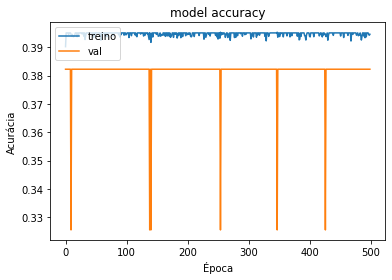

In [9]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9119 - class_loss: 1.2516 - speddup_loss: 3.3981 - class_acc: 0.4200 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9119. Test acc: 1.25
Confusion matrix:
[[840 198 642 320]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_control-data-call_trained_epochs500_batch16_1616206889.2601879/confusion_matrix.pdf


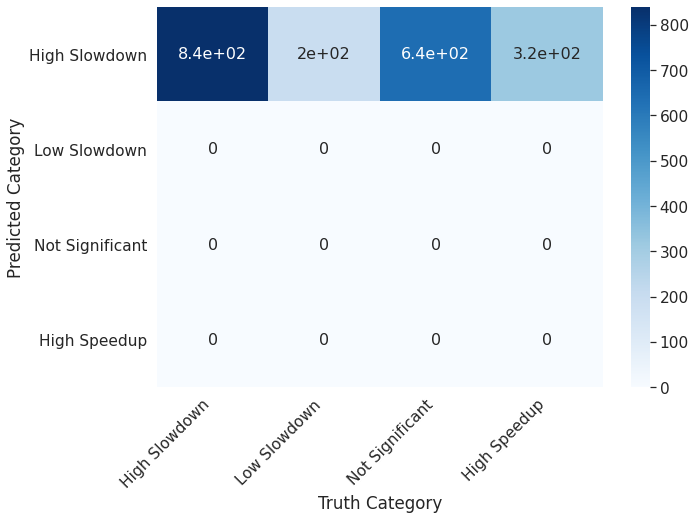

In [10]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (CONTROL, DATA)

In [11]:
# Read data
input_data = './data/cdfg_control-data_20000samples_150x150.npz'
tag = 'control-data'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_control-data_trained_epochs500_batch16_1616209963.0209906/info.yaml
Data loaded from ./data/cdfg_control-data_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

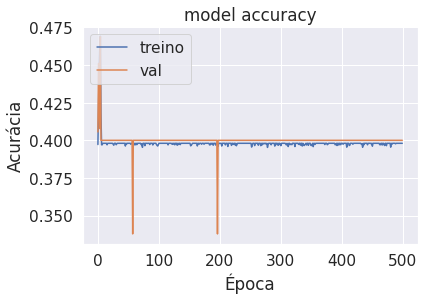

In [12]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9392 - class_loss: 1.2825 - speddup_loss: 89.7816 - class_acc: 0.3865 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9392. Test acc: 1.28
Confusion matrix:
[[773 219 656 352]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_control-data_trained_epochs500_batch16_1616209963.0209906/confusion_matrix.pdf


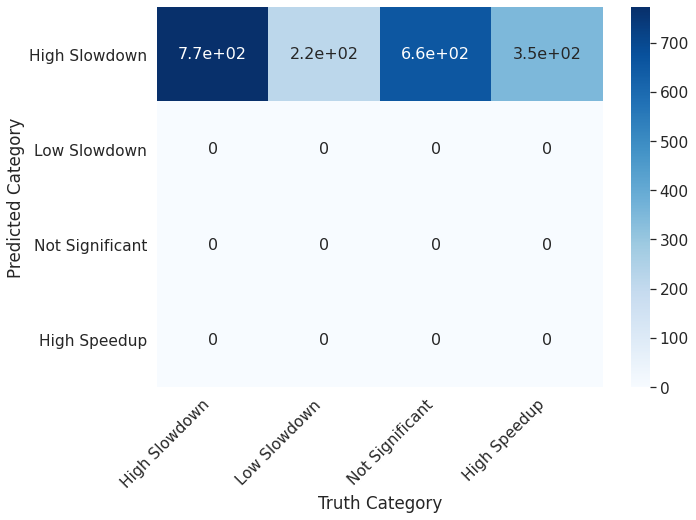

In [13]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (CONTROL, CALL)

In [14]:
# Read data
input_data = './data/cdfg_control-call_20000samples_150x150.npz'
tag = 'control-call'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_control-call_trained_epochs500_batch16_1616213094.1970775/info.yaml
Data loaded from ./data/cdfg_control-call_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

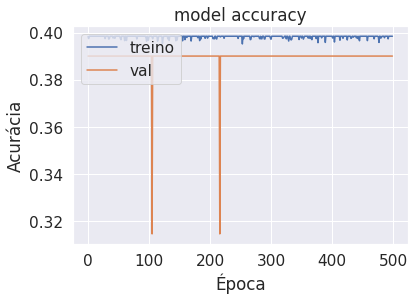

In [15]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9297 - class_loss: 1.2661 - speddup_loss: 69.5456 - class_acc: 0.3875 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9297. Test acc: 1.27
Confusion matrix:
[[775 196 689 340]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_control-call_trained_epochs500_batch16_1616213094.1970775/confusion_matrix.pdf


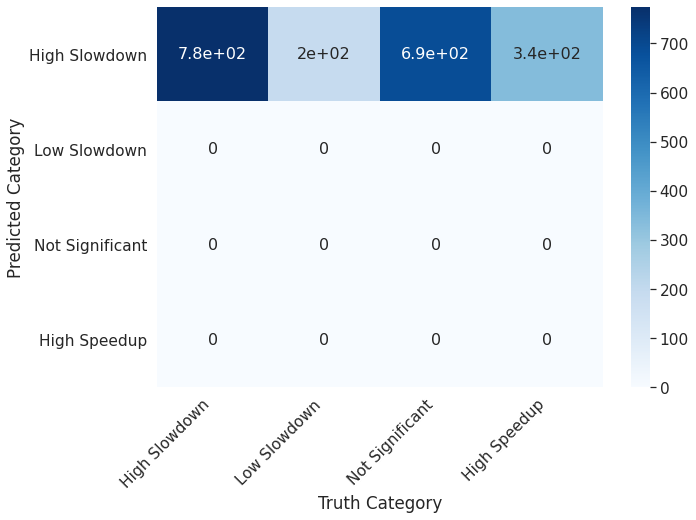

In [16]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (DATA, CALL)

In [17]:
# Read data
input_data = './data/cdfg_data-call_20000samples_150x150.npz'
tag = 'control'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_control_trained_epochs500_batch16_1616216180.1156578/info.yaml
Data loaded from ./data/cdfg_data-call_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

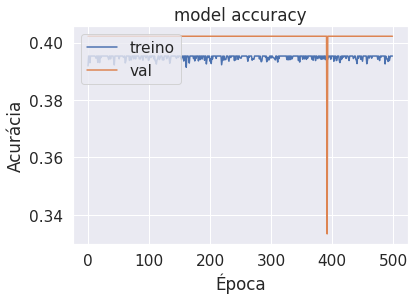

In [18]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9310 - class_loss: 1.2684 - speddup_loss: 77.1564 - class_acc: 0.4085 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9310. Test acc: 1.27
Confusion matrix:
[[817 205 627 351]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_control_trained_epochs500_batch16_1616216180.1156578/confusion_matrix.pdf


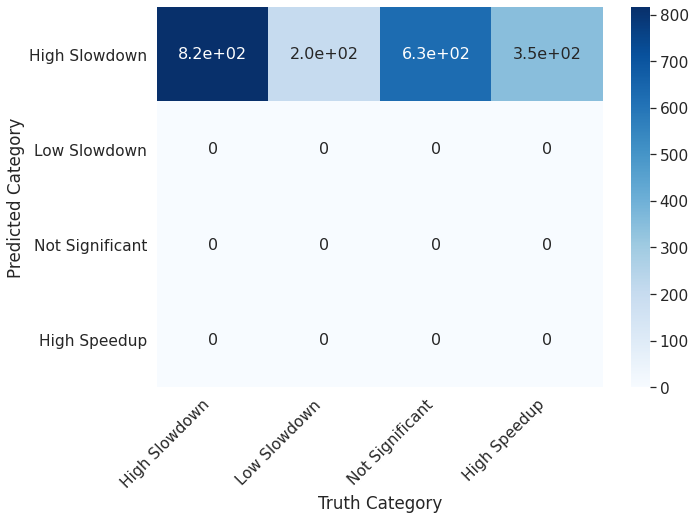

In [19]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (CONTROL)

In [20]:
# Read data
input_data = './data/cdfg_control_20000samples_150x150.npz'
tag = 'control'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_control_trained_epochs500_batch16_1616219267.575044/info.yaml
Data loaded from ./data/cdfg_control_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

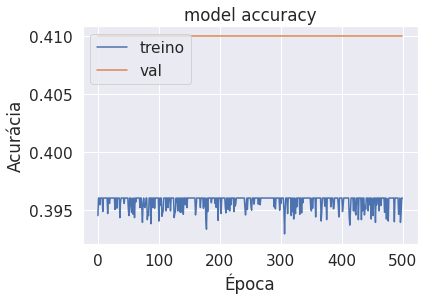

In [21]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9203 - class_loss: 1.2588 - speddup_loss: 28.3779 - class_acc: 0.3990 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9203. Test acc: 1.26
Confusion matrix:
[[798 196 676 330]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_control_trained_epochs500_batch16_1616219267.575044/confusion_matrix.pdf


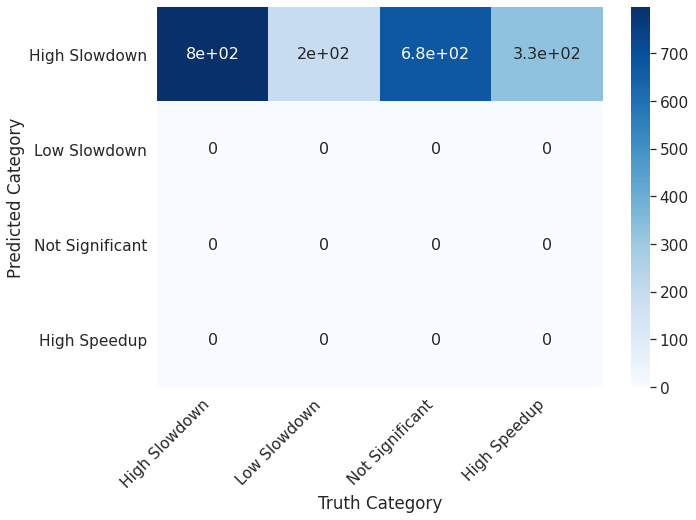

In [22]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (DATA)

In [23]:
# Read data
input_data = './data/cdfg_data_20000samples_150x150.npz'
tag = 'data'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_data_trained_epochs500_batch16_1616222361.1260304/info.yaml
Data loaded from ./data/cdfg_data_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

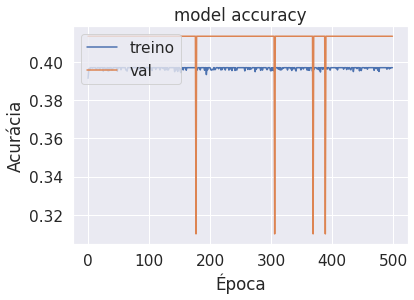

In [24]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.9298 - class_loss: 1.2681 - speddup_loss: 64.3667 - class_acc: 0.3900 - speddup_acc: 0.0000e+00
Done. Test loss: 1.9298. Test acc: 1.27
Confusion matrix:
[[780 195 669 356]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_data_trained_epochs500_batch16_1616222361.1260304/confusion_matrix.pdf


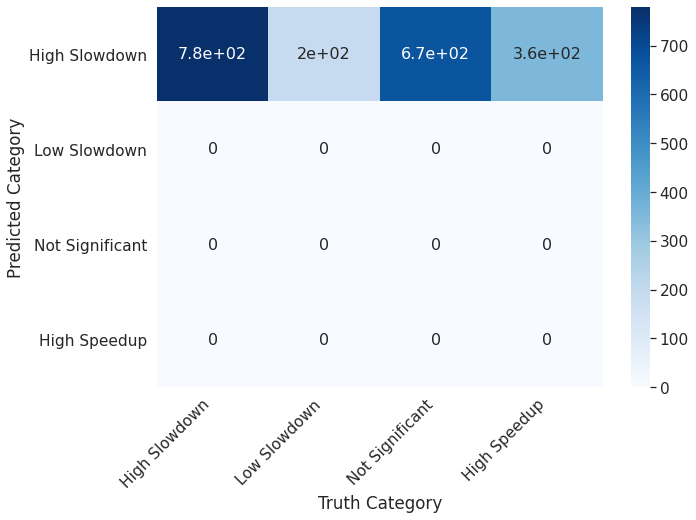

In [25]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")

## Training with (CALL)

In [26]:
# Read data
input_data = './data/cdfg_call_20000samples_150x150.npz'
tag = 'call'
n_nodes = 150                   # Number of nodes in the graphs
n_features = 200                # Original feature dimensionality
n_classes = 4                   # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

# Utils
data_dir = f'./model_data/GNN_cdfg_{tag}_trained_epochs{epochs}_batch{batch_size}_{time.time()}'
os.makedirs(data_dir, exist_ok=True)
dump_info(os.path.join(data_dir, 'info.yaml'), n_nodes, n_features, n_classes, epochs, batch_size, learning_rate)

A_train, A_test, x_train, x_test, y_train, y_test = get_inputs(input_data)
print("Inputs loaded!")

Information saved to ./model_data/GNN_cdfg_call_trained_epochs500_batch16_1616225450.779981/info.yaml
Data loaded from ./data/cdfg_call_20000samples_150x150.npz.
Speedup classes generated.
Datas:
        A shape (graphs): (20000, 2, 150, 150)
        X shape (features): (20000, 2, 150, 200)
        y shape (targets): (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 150, 150)]   0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 150, 150)]   0                                            
____________________________________________________________________________________________

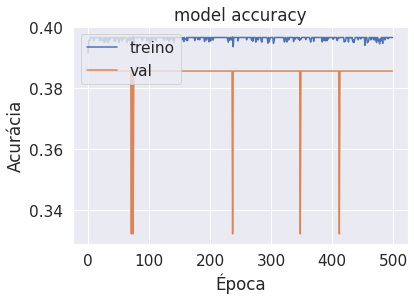

In [27]:
model = create_model(n_nodes, n_features, n_classes, learning_rate)
# Train model
history = model.fit([x_train[:,0,:,:], A_train[:,0,:,:], x_train[:,1,:,:], A_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=batch_size, validation_split=0.05, epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")
                     
save_model(os.path.join(data_dir, 'model.yaml'), output_weights_file = os.path.join(data_dir, 'weights.h5'))

Evaluating model.
125/125 [==============================] - 1s 3ms/step - loss: 1.6124 - class_loss: 1.2616 - speddup_loss: 45.7401 - class_acc: 0.4055 - speddup_acc: 0.0000e+00
Done. Test loss: 1.6124. Test acc: 1.26
Confusion matrix:
[[811 203 655 331]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Figure saved to ./model_data/GNN_cdfg_call_trained_epochs500_batch16_1616225450.779981/confusion_matrix.pdf


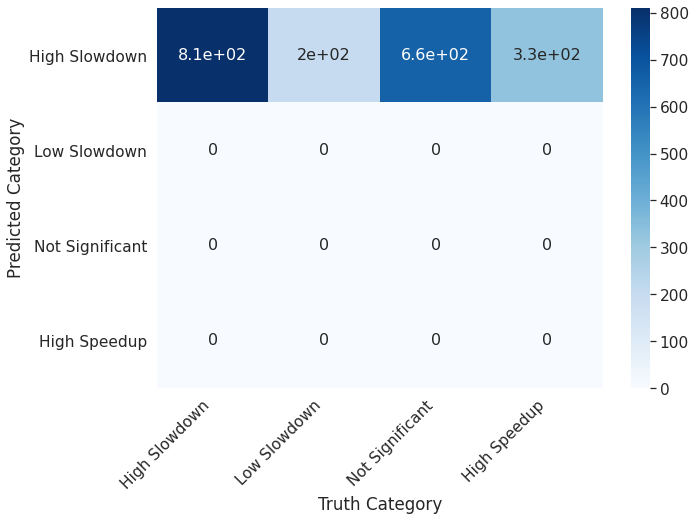

In [28]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
pred_vals = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(pred_vals,test_vals)
print(cm)

labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Figure saved to {figure_file}")